In [1]:
# Required libraries
import os
import math
import pims
from natsort import natsorted
import torch
import torch.nn as nn
from torch import Tensor
import random
import cv2 as cv
import numpy as np
import pandas as pd
import skimage as ski
from PIL import Image
import statistics
from PIL.ExifTags import TAGS
import matplotlib.pyplot as plt
from typing import Any, Callable, List, Optional, Type, Union
from tqdm import tqdm # for calculating mean, stdev (https://kozodoi.me/blog/20210308/compute-image-stats)
from itertools import islice # for taking first n elements from an iterable (dataloader object)
from torchinfo import summary
import wandb
from datetime import datetime

from torch.utils.data import Dataset, DataLoader, random_split

from torchvision.models import resnet101, ResNet101_Weights, resnet50, ResNet50_Weights
from torchvision.io import read_image
from torchvision.utils import save_image
from torch.utils.checkpoint import checkpoint
from torchvision.transforms import v2 as transforms

from transformers import AutoModel

# from pythae.models import AE, AEConfig, AutoModel
# from pythae.trainers import BaseTrainerConfig
# from pythae.pipelines.training import TrainingPipeline
# from pythae.models.nn.benchmarks.celeba import Encoder_ResNet_AE_CELEBA, Decoder_ResNet_AE_CELEBA, Encoder_Conv_AE_CELEBA, Decoder_Conv_AE_CELEBA, Encoder_ResNet_VAE_CELEBA
# from pythae.data.datasets import DatasetOutput
# from pythae.samplers import NormalSampler
from pythae.trainers.training_callbacks import WandbCallback

os.environ['WANDB_DATA_DIR'] = '/hps/nobackup/birney/users/esther/wandb/artifacts/staging/'
os.environ['WANDB_TIMEOUT'] = '120'
os.environ['JAVA_HOME'] = '/hps/nobackup/birney/users/esther/Fiji.app/java/linux-amd64/zulu8.60.0.21-ca-fx-jdk8.0.322-linux_x64/jre/'

In [2]:
! module load cuda/12.2.0

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.version.cuda)

12.1


In [4]:
torch.manual_seed(1)

In [5]:
# Set working directory
os.chdir('/nfs/research/birney/users/esther/medaka-img/src_files/')
model_dir = '/hps/nobackup/birney/users/esther/medaka-img/models/'

In [6]:
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ey267 (ey267-university-of-cambridge). Use `wandb login --relogin` to force relogin


True

## Build the vanilla autoencoder
Reshape the input image into a 224x224-dimensional vector and feed this into the autoencoder

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, dim0, dim1, dim2, dim3, dim4):
        super(AutoEncoder, self).__init__()
        # encoder
        self.fc1 = nn.Linear(input_dim, dim0)
        self.fc2 = nn.Linear(dim0, dim1)
        self.fc3 = nn.Linear(dim1, dim2)
        self.fc4 = nn.Linear(dim2, dim3)
        self.fc5 = nn.Linear(dim3, dim4)
        # decoder
        self.fc6 = nn.Linear(dim4, dim3)
        self.fc7 = nn.Linear(dim3, dim2)
        self.fc8 = nn.Linear(dim2, dim1)
        self.fc9 = nn.Linear(dim1, dim0)
        self.fc10 = nn.Linear(dim0, input_dim)

    def encoder(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        return x

    def decoder(self, x):
        x = torch.sigmoid(self.fc6(x))
        x = torch.sigmoid(self.fc7(x))
        x = torch.sigmoid(self.fc8(x))
        x = torch.sigmoid(self.fc9(x))
        x = torch.sigmoid(self.fc10(x))
        return x
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, dim0, dim1, dim2, dim3, dim4):
        super(AutoEncoder, self).__init__()
        # encoder
        self.fc1 = nn.Linear(input_dim, dim0)
        self.fc2 = nn.Linear(dim0, dim1)
        self.fc3 = nn.Linear(dim1, dim2)
        self.fc4 = nn.Linear(dim2, dim3)
        self.fc5 = nn.Linear(dim3, dim4)
        # decoder
        self.fc6 = nn.Linear(dim4, dim3)
        self.fc7 = nn.Linear(dim3, dim2)
        self.fc8 = nn.Linear(dim2, dim1)
        self.fc9 = nn.Linear(dim1, dim0)
        self.fc10 = nn.Linear(dim0, input_dim)

    def encoder(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        return x

    def decoder(self, x):
        x = torch.relu(self.fc6(x))
        x = torch.relu(self.fc7(x))
        x = torch.relu(self.fc8(x))
        x = torch.relu(self.fc9(x))
        x = torch.relu(self.fc10(x))
        return x
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [8]:
num_input = 224*224 # 50176

num_hidden_0 = 7168
num_hidden_1 = 1024
num_hidden_2 = 512
num_hidden_3 = 256
num_hidden_4 = 128


model = AutoEncoder(num_input, num_hidden_0, num_hidden_1, num_hidden_2, num_hidden_3, num_hidden_4)

In [9]:
summary(model, input_size=(1, 224*224))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [1, 50176]                --
├─Linear: 1-1                            [1, 7168]                 359,668,736
├─Linear: 1-2                            [1, 1024]                 7,341,056
├─Linear: 1-3                            [1, 512]                  524,800
├─Linear: 1-4                            [1, 256]                  131,328
├─Linear: 1-5                            [1, 128]                  32,896
├─Linear: 1-6                            [1, 256]                  33,024
├─Linear: 1-7                            [1, 512]                  131,584
├─Linear: 1-8                            [1, 1024]                 525,312
├─Linear: 1-9                            [1, 7168]                 7,347,200
├─Linear: 1-10                           [1, 50176]                359,711,744
Total params: 735,447,680
Trainable params: 735,447,680
Non-trainable params: 0
Total mult-adds

## Configure wandb

In [10]:
config = dict(
    epochs=21,
    batch_size=32,
    learning_rate=0.001,
    dataset="medaka-img-2024-10-03",
    architecture="Vanilla autoencoder (Tom) - relu activation",
    model="vanilla-ae",
    train_img_rotation=10, # How much to rotate images during training
    ckpt_freq=50, # How often to save model checkpoints
    ckpt_dir=model_dir, # Directory to save model checkpoints
    reconstruction_table_freq=50, # How often to save reconstruction table

)

print(config['batch_size'])

32


## Load medaka data

In [11]:
# Custom min-max scaling function to pass into Compose; transforms pixel values to range [0,1] for each image individually
class MinMaxScaling:
    def __call__(self, tensor):
        return (tensor - tensor.min()) / (tensor.max() - tensor.min())

In [12]:
# Compose image transformations
# Based on testing below, MinMax scaling is the best normalization method for this dataset
# Using mean and std of the dataset for normalization is maybe not representative of the entire dataset,
# as the maximum value after normalization is 431.33228 (eg. subtracting the max pixel value, )
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda img: transforms.functional.crop(img, 0, 0, 980, 1392)), # crop out bottom text
    transforms.Resize((224, 224)),
    # transforms.Resize((979, 979)), # resize to 979x979 to give 490x490 after first conv
    # transforms.RandomCrop(64), # crop to 64x64
    # transforms.Normalize(mean=(0, 0, 0), std=(1, 1, 1)) # temporarily, to get the mean and stdev of the dataset
    # transforms.Normalize(mean=(0.035028, 0.000052371, 0.00043022), std=(0.0600, 0.0013, 0.0028))
    # transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # imagenet normalization -> returns black images
    MinMaxScaling() # custom normalization
])

/hps/software/users/birney/esther/micromamba/envs/indigene-img/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Flip all left-facing images to the right within the MedakaDataset class

In [13]:
# Read in dataframe indicating whether the fish is facing left or right
fish_direction_df= pd.read_csv("/nfs/research/birney/users/esther/medaka-img/scripts/left-facing-fish.csv")

# Only keep rows where the fish is facing left
fish_left_df = fish_direction_df[fish_direction_df['left_facing'] == 'left']
fish_left_df = fish_left_df.rename(columns={'Unnamed: 0': 'img_name'})

In [14]:
class MedakaDataset(Dataset):
    def __init__(self, csv_file, src_dir, transform=transform):
        self.image_paths = pd.read_csv(csv_file)['img_name']
        self.src_dir = src_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        img_path = f'{self.src_dir}/{img_name}'
                
        image = ski.io.imread(img_path)[:,:,0]

        # Convert to tensor, crop out bottom text, and normalize
        if self.transform is not None:
            image = self.transform(image)

        # If facing left, flip the image horizontally
        if os.path.splitext(img_name)[0] in fish_left_df['img_name'].values:
            image = transforms.functional.hflip(image)

        return image.to(device), img_name # in script cannot use .to(device) here

In [15]:
# Load dataset
dataset = MedakaDataset(csv_file='train_set_2024-10-03.csv', 
                                src_dir='/nfs/research/birney/users/esther/medaka-img/src_files/train_2024-10-03/raw_images', 
                                transform=transform)

train_len = int(len(dataset) * 0.8)
val_len = len(dataset) - train_len

train_dataset, val_dataset = random_split(dataset, [train_len, val_len])

print(f"Train length: {train_len}")
print(f"Validation length: {val_len}")

Train length: 889
Validation length: 223


In [43]:
# import json
# with open("/nfs/research/birney/users/esther/medaka-img/src_files/wandb_json/vanilla-ae-v0.json", "r") as file:
#     config = json.load(file)

# print(config)

# print(config['batch_size'])

{'epochs': 21, 'batch_size': 32, 'learning_rate': 0.001, 'dataset': 'train_set_2024-10-03.csv', 'architecture': 'Vanilla autoencoder (Tom)', 'model': 'vanilla-ae', 'train_img_rotation': 10, 'ckpt_freq': 50, 'ckpt_dir': '/hps/nobackup/birney/users/esther/medaka-img/models/', 'reconstruction_table_freq': 50}
32


In [61]:
# import yaml
# with open("/nfs/research/birney/users/esther/medaka-img/src_files/wandb_yaml/vanilla-ae-v1.yaml", "r") as file:
#     config = yaml.load(file, Loader=yaml.FullLoader)

# print(config)
# # print(config['ckpt_dir'])
# # print(config.get('ckpt_dir'))
# print(config['parameters']['project_name'])

{'method': 'bayes', 'metric': {'goal': 'minimize', 'name': 'val_loss'}, 'parameters': {'learning_rate': {'values': [0.001, 0.0001, 1e-05]}, 'batch_size': {'values': [4, 8, 16, 32, 64]}, 'epochs': {'values': [5, 10, 15]}, 'project_name': 'vanilla-ae-pytorch-medaka', 'architecture': 'Vanilla autoencoder (Tom)', 'ckpt_dir': '/hps/nobackup/birney/users/esther/medaka-img/models/', 'ckpt_freq': [10], 'criterion': 'MSELoss', 'data_csv': '/nfs/research/birney/users/esther/medaka-img/src_files/train_set_2024-10-03.csv', 'data_dir': '/nfs/research/birney/users/esther/medaka-img/src_files/train_2024-10-03/raw_images/', 'direction_csv': '/nfs/research/birney/users/esther/medaka-img/scripts/left-facing-fish.csv', 'model': 'vanilla-ae', 'optimizer': 'adam', 'reconstruction_table_freq': [10], 'train_img_rotation': [10], 'train_split': [0.8]}}
vanilla-ae-pytorch-medaka


In [62]:
# for parameter_name in config['parameters']:
#     parameter = config["parameters"][parameter_name]
#     print(parameter_name)
#     if "min" in parameter:
#         print("min")
#     if "max" in parameter:
#         print("max")

learning_rate
batch_size
epochs
project_name
architecture
ckpt_dir
ckpt_freq
criterion
data_csv
data_dir
direction_csv
model
optimizer
reconstruction_table_freq
train_img_rotation
train_split


Implement checkpointing

In [16]:
def save_checkpoint(model, optimizer, epoch, filename="checkpoint.pth.tar"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    torch.save(checkpoint, filename)

def load_checkpoint(filename, model, optimizer):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch']

## Create training loop

In [17]:
random_trans = transforms.Compose([
        transforms.RandomRotation(config['train_img_rotation'])
    ])

In [18]:
def make(config):
    # Make the data
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'])

    # Make the model
    model = AutoEncoder(num_input, num_hidden_0, num_hidden_1, num_hidden_2, num_hidden_3, num_hidden_4).to(device)

    # Make the loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(
        model.parameters(), lr=config['learning_rate'])
    
    return model, train_loader, val_loader, criterion, optimizer

In [20]:
def train(model, train_loader, val_loader, criterion, optimizer, run_name, config):
    # Tell wandb to watch what the model gets up to: gradients, weights, and more!
    wandb.watch(model, criterion, log="all", log_freq=10)

    # Create wandb table
    columns = ["epoch", "id", "image", "reconstructed"]
    test_table = wandb.Table(columns=columns)

    # Run training and track with wandb
    example_ct = 0  # number of examples seen
    batch_ct = 0

    for epoch in tqdm(range(config['epochs'])):
        model.train()
        for image, image_name in train_loader:
            image = torch.reshape(random_trans(image),(-1, 224*224))
            train_loss = train_batch(image, model, optimizer, criterion)
            example_ct +=  len(image) # the batch size
            batch_ct += 1

        train_log(train_loss, example_ct, epoch)

        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for image, image_name in val_loader:
                image = torch.reshape(image,(-1, 224*224))
                image = image.to(device)
                output = model(image)
                loss = criterion(output, image)
                val_loss += loss.item()

            val_loss /= len(val_loader)
            wandb.log({"val_loss": val_loss}, step=epoch)
            print(f"Validation loss: {val_loss:.5f}")
            
        # Every 20th epoch, save model checkpoint
        # if (epoch % 5 == 0): #and (epoch != 0):
        #     # date_time = datetime.now().strftime("%Y%m%d%H%M%S")
        #     ckpt_name = f"ckpt-model-{config['model']}-run-{run_name}-epoch-{epoch}-val_loss-{val_loss:.5f}"    

        #     # save_checkpoint(model, optimizer, epoch, filename=f'{model_dir}/checkpoints/vanilla-ae-pytorch-medaka/{ckpt_name}-{date_time}.pt')
        #     save_checkpoint(model, optimizer, epoch, filename=f'{model_dir}/checkpoints/vanilla-ae-pytorch-medaka/{run_name}/{ckpt_name}.pt')

        #     # model_checkpoint = wandb.Artifact(
        #     #     name=ckpt_name,
        #     #     type="model").add_file(local_path=f'{model_dir}/checkpoints/vanilla-ae-pytorch-medaka/{ckpt_name}-{date_time}.pt')

        #     # assert isinstance(model_checkpoint, wandb.Artifact), "model_checkpoint is not a wandb.Artifact"

        #     wandb.log_artifact(
        #         artifact_or_path=f'{model_dir}/checkpoints/vanilla-ae-pytorch-medaka/{run_name}/{ckpt_name}.pt', 
        #         type="model-checkpoint",
        #         aliases=[f"model={config['model']}", f"architecture={config['architecture']}", f"epoch={epoch}", f"run={run_name}"])   


        # Every 50th epoch, output image reconstruction
        if (epoch % 10 == 0):
            print("Logging table at epoch", epoch)
            show_img, id = val_dataset[0]
            recon_img = model(torch.reshape(show_img, (-1, 224*224)).to(device)).reshape(224, 224).cpu().detach().to(torch.float32)
            test_table.add_data(epoch, id, wandb.Image(show_img), wandb.Image(recon_img))
            test_table = wandb.Table(columns=columns, data=test_table.data)
            wandb.log({"Image reconstruction performance": test_table})


def train_batch(image, model, optimizer, criterion):
    image = image.to(device)
    
    # Forward pass
    output = model(image)
    loss = criterion(output, image)
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()

    return loss

def train_log(loss, example_ct, epoch):
    # Where the magic happens
    wandb.log({"epoch": epoch, "train loss": loss}, step=epoch)
    print(f"Loss after {str(example_ct).zfill(5)} examples: {loss:.5f}")

In [20]:
def test(model, test_loader, criterion):
    model.eval()

    # Run the model on some test examples
    with torch.no_grad():
        for image, image_name in test_loader:
            image = image.to(device)
            output = model(image)
            loss = criterion(output, image)
            

        print(f"Test Loss: {loss:.3f}")
        
        wandb.log({"vali": correct / total})

    # Save the model in the exchangeable ONNX format
    torch.onnx.export(model, image, "model.onnx")
    wandb.save("model.onnx")

In [21]:
def model_pipeline(hyperparameters):
    run = wandb.init(project="vanilla-ae-pytorch-medaka", config=hyperparameters)
    # tell wandb to get started
    with run:
      run_name = run.name
      # make the model, data, and optimization problem
      model, train_loader, val_loader, criterion, optimizer = make(hyperparameters)

      # and use them to train the model
      train(model, train_loader, val_loader, criterion, optimizer, run_name, hyperparameters)

      # and test its final performance
      # test(model, test_loader)

    run.finish()

    return model, run_name

In [22]:
model, run_name = model_pipeline(config)

torch.cuda.empty_cache()
print(run_name)

  0%|          | 0/21 [00:00<?, ?it/s]

Loss after 00889 examples: 0.00751
Validation loss: 0.00695
Logging table at epoch 0


  5%|▍         | 1/21 [00:25<08:23, 25.16s/it]

Loss after 01778 examples: 0.00689


 10%|▉         | 2/21 [00:36<05:28, 17.31s/it]

Validation loss: 0.00666
Loss after 02667 examples: 0.00727


 14%|█▍        | 3/21 [00:46<04:07, 13.75s/it]

Validation loss: 0.00591
Loss after 03556 examples: 0.00566


 19%|█▉        | 4/21 [00:57<03:38, 12.86s/it]

Validation loss: 0.00525
Loss after 04445 examples: 0.00562


 24%|██▍       | 5/21 [01:07<03:06, 11.67s/it]

Validation loss: 0.00506
Loss after 05334 examples: 0.00459


 29%|██▊       | 6/21 [01:18<02:51, 11.46s/it]

Validation loss: 0.00489
Loss after 06223 examples: 0.00547


 33%|███▎      | 7/21 [01:28<02:31, 10.83s/it]

Validation loss: 0.00449
Loss after 07112 examples: 0.00449


 38%|███▊      | 8/21 [01:39<02:22, 10.95s/it]

Validation loss: 0.00423
Loss after 08001 examples: 0.00405


 43%|████▎     | 9/21 [01:48<02:06, 10.50s/it]

Validation loss: 0.00424
Loss after 08890 examples: 0.00421


 48%|████▊     | 10/21 [02:00<01:58, 10.74s/it]

Validation loss: 0.00405
Loss after 09779 examples: 0.00444
Validation loss: 0.00391
Logging table at epoch 10


 52%|█████▏    | 11/21 [02:10<01:45, 10.55s/it]

Loss after 10668 examples: 0.00403


 57%|█████▋    | 12/21 [02:21<01:36, 10.77s/it]

Validation loss: 0.00386
Loss after 11557 examples: 0.00390


 62%|██████▏   | 13/21 [02:31<01:23, 10.41s/it]

Validation loss: 0.00385
Loss after 12446 examples: 0.00420


 67%|██████▋   | 14/21 [02:42<01:15, 10.80s/it]

Validation loss: 0.00388
Loss after 13335 examples: 0.00377


 71%|███████▏  | 15/21 [02:52<01:02, 10.44s/it]

Validation loss: 0.00383
Loss after 14224 examples: 0.00408


 76%|███████▌  | 16/21 [03:03<00:53, 10.70s/it]

Validation loss: 0.00377
Loss after 15113 examples: 0.00383


 81%|████████  | 17/21 [03:13<00:41, 10.36s/it]

Validation loss: 0.00375
Loss after 16002 examples: 0.00364


 86%|████████▌ | 18/21 [03:24<00:32, 10.68s/it]

Validation loss: 0.00369
Loss after 16891 examples: 0.00359


 90%|█████████ | 19/21 [03:34<00:20, 10.38s/it]

Validation loss: 0.00364
Loss after 17780 examples: 0.00408


 95%|█████████▌| 20/21 [03:45<00:10, 10.70s/it]

Validation loss: 0.00372
Loss after 18669 examples: 0.00390
Validation loss: 0.00362
Logging table at epoch 20


100%|██████████| 21/21 [03:55<00:00, 11.23s/it]


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
train loss,█▇█▅▅▃▄▃▂▂▃▂▂▂▁▂▁▁▁▂▂
val_loss,█▇▆▄▄▄▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁
epoch,20
train loss,0.0039
val_loss,0.00362


stilted-energy-34


In [28]:
torch.cuda.empty_cache()
# print(run_name)

In [22]:
# Save trained model
torch.save(model.state_dict(), "/nfs/research/birney/users/esther/medaka-img/src_files/vanilla-ae-medaka/polished-snow-11.pth")

In [23]:
# Read model back in
model = AutoEncoder(num_input, num_hidden_0, num_hidden_1, num_hidden_2, num_hidden_3, num_hidden_4)
model.load_state_dict(torch.load("/nfs/research/birney/users/esther/medaka-img/src_files/vanilla-ae-medaka/dainty-breeze-4.pth"))

<All keys matched successfully>

torch.Size([1, 224, 224])


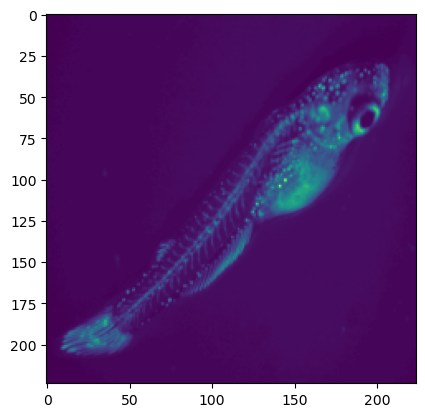

In [24]:
train_example = train_dataset[393]

print(train_example[0].shape)
plt.imshow(train_example[0].permute(1, 2, 0).cpu().numpy())

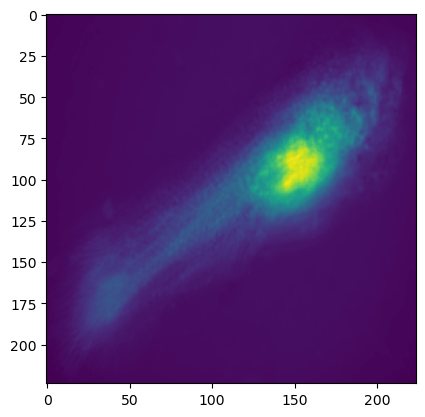

In [25]:
model.to(device)
model_output = model(train_example[0].reshape(-1, 224*224).to(device))

model_output = model_output.reshape(224, 224)
plt.imshow(model_output.cpu().detach().numpy())

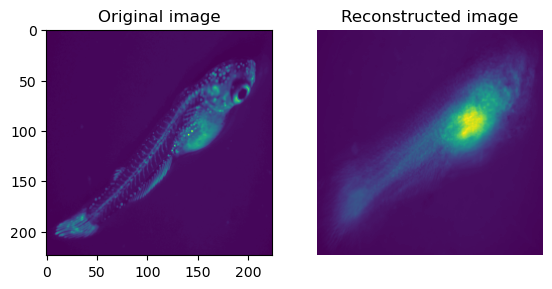

In [26]:
fig, axs = plt.subplots(1,2)

axs[0].imshow(train_example[0].permute(1, 2, 0).cpu().numpy())
axs[0].set_title('Original image')

axs[1].imshow(model_output.cpu().detach().numpy())
axs[1].set_title('Reconstructed image')
axs[1].axis('off')

plt.show()

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

: 